# ROB 498-011/599-011 Final Project: Tiny-NeRF Object Gesture Control

Michael Guertler, Sagar Patil, Adithya Ramakrishnan, Tyler Smithline

# Setup

In [2]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [3]:
running_colab = 'google.colab' in str(get_ipython())

if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print('Running locally')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os, sys
from os import path
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import time
import os, sys
import cv2
import math
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow

if running_colab:
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None

    # Add your own path here and comment out the others when you run this
    # GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "599 - Deep Learning/Final Project/TinyNeRF") # Michael
    # GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "ROB 599 Deep Learning Rob Perception/Final Project/TinyNeRF") # Adithya
    GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "Spring 2024/ROB 599/Final Project/TinyNeRF") # Tyler


print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is set to: ', device)

['test_ray_d.pt', 'p4_helper.py', 'test_ray_o.pt', '__pycache__', 'tiny_nerf.py', 'nerf.pth', 'pred_image.pt', 'tiny_nerf_pytorch.ipynb', 'imgs.pkl', 'Output_Images']
Device is set to:  cuda


### Download and Load Data

In [5]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz --no-check-certificate

# Here we have 106 images of a block toy construction vehicle. The data includes the RGB image, pose, and focal point.
data = np.load('tiny_nerf_data.npz')
images = torch.tensor(data['images'],device=device)
poses = torch.tensor(data['poses'],device=device)
focal = torch.tensor(data['focal'],device=device)
H, W = images.shape[1:3]
testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

# Gesture Control

In [6]:
from tiny_nerf import *
model = nerf(depth=8, width=256, num_embed=6)
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH,'nerf.pth')))
optimizer = optim.Adam(model.parameters(), lr=5e-4)
model.to(device)

nerf(
  (model): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=295, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=4, bias=True)
  )
)

## Hand tracking setup

In [7]:
# !pip install mediapipe
import mediapipe as mp

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Create functions that will allow for gesture control
def take_photo(filename='photo.jpg', quality=0.3):
    js = Javascript('''
        async function takePhoto(quality) {
            const canvas = document.createElement('canvas');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            const video = document.createElement('video');
            video.srcObject = stream;
            await video.play();
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            //stream.getVideoTracks()[0].stop();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

#Transformation Matrices
N_samples = 64
trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)

# Define the pose_spherical function
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w.numpy()
    return torch.tensor(c2w, dtype=torch.float32, device=device)

def render_image(theta, phi, radius):
    # Define your NeRF-related parameters and model here
    N_samples = 64  # Number of samples for rendering
    near = 2.0      # Near depth
    far = 6.0       # Far depth

    # Convert theta, phi, radius to camera-to-world transformation
    c2w = pose_spherical(theta, phi, radius)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])  # Assuming you have get_rays() function defined
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=near, far=far, N_samples=N_samples)  # Assuming you have render_rays() function defined
    img = torch.clip(rgb, 0, 1)  # Clip the image values between 0 and 1

    return img

## TinyNeRF Gesture Control

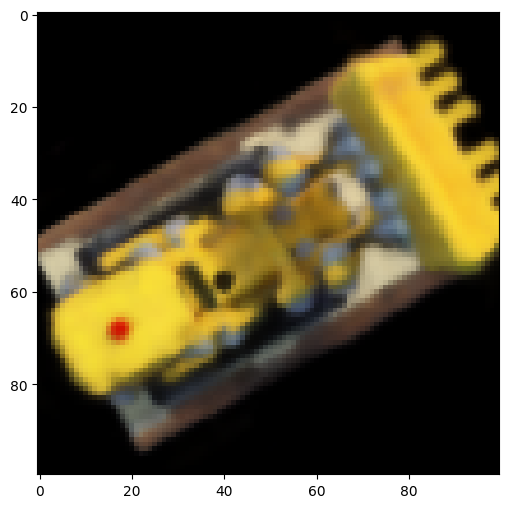

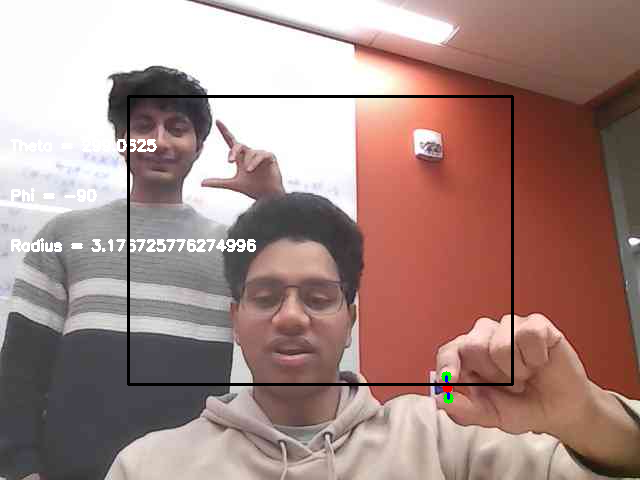

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import Image

while(True):
    # time.sleep(2)
    frame = cv2.imread(take_photo())

    # Convert the displayed image to a NumPy array
    frame = np.array(frame)

    # # Flip the frame horizontally to revert it to its original orientation
    frame = cv2.flip(frame, 1)  #makes movement mirrored and not flipped

    H_frame, W_frame, C_frame = frame.shape       #assume unchanged shape. Get frame sizes

    # Convert the image to RGB --> MediaPipe needs this format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the image with MediaPipe
    results = hands.process(rgb_frame)


    clear_output(wait=True)

    # If hand(s) are detected, draw landmarks on the frame
    if results.multi_hand_landmarks:
        # for hand_landmarks in results.multi_hand_landmarks:    #this line annotates all visible hands. Indent lines below if kept
        hand_landmarks = results.multi_hand_landmarks[-1]         #ONLY detects/annotates the last hand. Keep either this or above line
        for idx, landmark in enumerate(hand_landmarks.landmark):
            # Convert normalized coordinates to pixel coordinates
            h, w, c = frame.shape
            cx, cy = int(landmark.x * w), int(landmark.y * h)

            # Draw a circle and number on each landmark
            #Only display dots (and text) for tip of index & thumb.
            if (idx == 4) or (idx == 8):
                cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)

        # Get the pixel coordinates of landmarks 4 and 8
        index4_x, index4_y = int(hand_landmarks.landmark[4].x * w), int(hand_landmarks.landmark[4].y * h)
        index8_x, index8_y = int(hand_landmarks.landmark[8].x * w), int(hand_landmarks.landmark[8].y * h)

        # calculate length of line between 4,8
        line_dist = math.sqrt((index4_x-index8_x)**2 + (index4_y-index8_y)**2)

        # Get median point of line between 4,8 --> point that will be tracked
        median_x = int((index4_x + index8_x)/2)
        median_y = int((index4_y + index8_y)/2)

        #Convert median point coordinates to theta, phi, radius values. Range values used from P4
        theta = ((median_x - 0.2*W_frame) / (0.8*W_frame - 0.2*W_frame)) * 360
        theta = max(0, min(360, theta))
        phi = ((median_y - 0.2*H_frame) / (0.8*H_frame - 0.2*H_frame)) * ((-90) - 0) + 0 # map y_position from 0.2*H-0.8*H to [-90, 0]
        phi = max(-90, min(0, phi))                                 # values < 0.2*H = -90. values > 0.8*H = 0. Prevent hand from leaving screen just to reach these limits
        radius = min( ((line_dist/250 * (5 - 3)) + 3), 5)      # ^^. Map to range [3, 5]

        img = render_image(theta, phi, radius)

        plt.figure(2, figsize=(20,6))
        plt.imshow(img.detach().cpu().numpy())
        plt.show()

        # Draw a line between landmarks 4 and 8
        cv2.line(frame, (index4_x, index4_y), (index8_x, index8_y), (255, 0, 0), 2)
        # Draw the median point (should lie on the center of the line)
        cv2.circle(frame, (median_x, median_y), 5, (0, 0, 255), -1)
        cv2.putText(frame, "Theta = " + str(theta), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Theta
        cv2.putText(frame, "Phi = " + str(phi), (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Phi
        cv2.putText(frame, "Radius = " + str(radius), (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Line_dist

        # Draw lines to show effective tracking area of screen. (Width: 0*W_frame - 0.8*W_frame) (Height: 0.2*H_frame - 0.8*H_frame)
        cv2.line(frame, (int(0.2*W_frame), int(0.2*H_frame)), (int(0.8*W_frame), int(0.2*H_frame)), (0, 0, 0), 2)     # top horizontal line    @ 0.2*H_frame
        cv2.line(frame, (int(0.2*W_frame), int(0.8*H_frame)), (int(0.8*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # bottom horizontal line @ 0.8*H_frame
        cv2.line(frame, (int(0.2*W_frame), int(0.2*H_frame)), (int(0.2*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # right vertical line    @ 0.8*W_frame
        cv2.line(frame, (int(0.8*W_frame), int(0.2*H_frame)), (int(0.8*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # right vertical line    @ 0.8*W_frame

    # Display the annotated frame
    cv2_imshow(frame)

## Preloading Images

In [8]:
theta_space = np.linspace(0.0, 360.0, num=61)[:22]
phi_space = np.linspace(-90.0, 0.0, num=31)
radius_space = np.linspace(3.0, 5.0, num=5)

def find_nearest(theta, phi, radius):
    # print("nearest output", np.argmin(np.abs(theta_space - theta)), theta_space-theta)
    n_theta = theta_space[np.argmin(np.abs(theta_space - theta))]
    n_phi = phi_space[np.argmin(np.abs(phi_space - phi))]
    n_radius = radius_space[np.argmin(np.abs(radius_space - radius))]
    return n_theta, n_phi, n_radius

def low_pass_filter(current_value, previous_output, alpha):
    """
    Applies a low-pass filter (Exponential Moving Average) to the current value.

    Args:
        current_value (float): The current input value.
        previous_output (float): The previous output value.
        alpha (float): Smoothing factor, between 0 and 1. Higher values give more weight to recent data.

    Returns:
        float: The filtered output value.
    """
    filtered_value = alpha * current_value + (1 - alpha) * previous_output
    return filtered_value

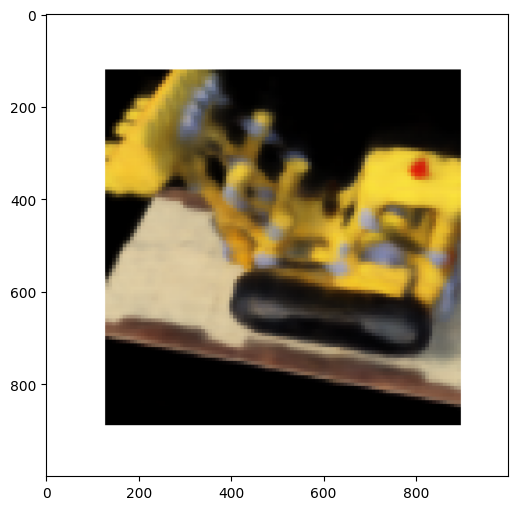

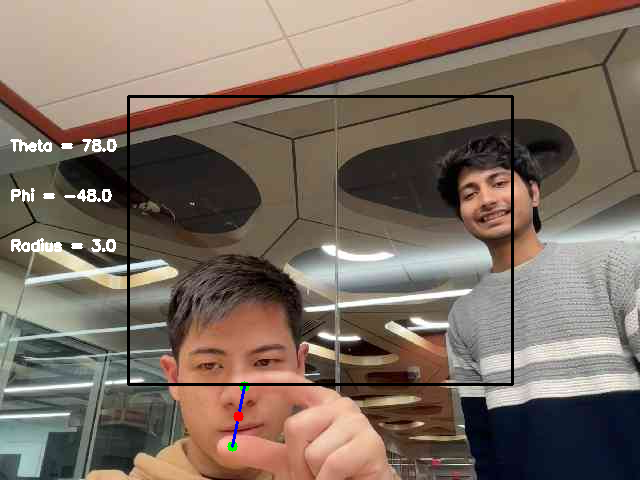

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [9]:
from IPython.display import Image
import imageio as iio

alpha = 0.1
filt_theta = 0
filt_phi = 0
filt_radius = 0

while(True):
    # time.sleep(2)
    frame = cv2.imread(take_photo())

    # Convert the displayed image to a NumPy array
    frame = np.array(frame)

    # # Flip the frame horizontally to revert it to its original orientation
    frame = cv2.flip(frame, 1)  #makes movement mirrored and not flipped

    H_frame, W_frame, C_frame = frame.shape       #assume unchanged shape. Get frame sizes

    # Convert the image to RGB --> MediaPipe needs this format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the image with MediaPipe
    results = hands.process(rgb_frame)


    clear_output(wait=True)

    # If hand(s) are detected, draw landmarks on the frame
    if results.multi_hand_landmarks:
        # for hand_landmarks in results.multi_hand_landmarks:    #this line annotates all visible hands. Indent lines below if kept
        hand_landmarks = results.multi_hand_landmarks[-1]         #ONLY detects/annotates the last hand. Keep either this or above line
        for idx, landmark in enumerate(hand_landmarks.landmark):
            # Convert normalized coordinates to pixel coordinates
            h, w, c = frame.shape
            cx, cy = int(landmark.x * w), int(landmark.y * h)

            # Draw a circle and number on each landmark
            #Only display dots (and text) for tip of index & thumb.
            if (idx == 4) or (idx == 8):
                cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)

        # Get the pixel coordinates of landmarks 4 and 8
        index4_x, index4_y = int(hand_landmarks.landmark[4].x * w), int(hand_landmarks.landmark[4].y * h)
        index8_x, index8_y = int(hand_landmarks.landmark[8].x * w), int(hand_landmarks.landmark[8].y * h)

        # calculate length of line between 4,8
        line_dist = math.sqrt((index4_x-index8_x)**2 + (index4_y-index8_y)**2)

        # Get median point of line between 4,8 --> point that will be tracked
        median_x = int((index4_x + index8_x)/2)
        median_y = int((index4_y + index8_y)/2)

        #Convert median point coordinates to theta, phi, radius values. Range values used from P4
        theta = ((median_x - 0.2*W_frame) / (0.8*W_frame - 0.2*W_frame)) * 360
        theta = max(0, min(360, theta))
        phi = ((median_y - 0.2*H_frame) / (0.8*H_frame - 0.2*H_frame)) * ((-90) - 0) + 0 # map y_position from 0.2*H-0.8*H to [-90, 0]
        phi = max(-90, min(0, phi))                                 # values < 0.2*H = -90. values > 0.8*H = 0. Prevent hand from leaving screen just to reach these limits
        radius = min( ((line_dist/250 * (5 - 3)) + 3), 5)      # ^^. Map to range [3, 5]

        filt_theta = low_pass_filter(theta, filt_theta, alpha)
        filt_phi = low_pass_filter(phi, filt_phi, alpha)
        filt_radius = low_pass_filter(radius, filt_radius, alpha)

        theta, phi, radius = find_nearest(filt_theta, filt_phi, filt_radius)

        # img = img_dict(theta, phi, radius)
        filename = "t{:.1f}_p{:.1f}_r{:.1f}.png".format(theta, phi, radius)
        img = iio.imread(GOOGLE_DRIVE_PATH + "/Output_Images/" + filename)

        plt.figure(2, figsize=(20,6))
        plt.imshow(img)
        plt.show()

        # Draw a line between landmarks 4 and 8
        cv2.line(frame, (index4_x, index4_y), (index8_x, index8_y), (255, 0, 0), 2)
        # Draw the median point (should lie on the center of the line)
        cv2.circle(frame, (median_x, median_y), 5, (0, 0, 255), -1)
        cv2.putText(frame, "Theta = " + str(theta), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Theta
        cv2.putText(frame, "Phi = " + str(phi), (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Phi
        cv2.putText(frame, "Radius = " + str(radius), (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Line_dist

        # Draw lines to show effective tracking area of screen. (Width: 0*W_frame - 0.8*W_frame) (Height: 0.2*H_frame - 0.8*H_frame)
        cv2.line(frame, (int(0.2*W_frame), int(0.2*H_frame)), (int(0.8*W_frame), int(0.2*H_frame)), (0, 0, 0), 2)     # top horizontal line    @ 0.2*H_frame
        cv2.line(frame, (int(0.2*W_frame), int(0.8*H_frame)), (int(0.8*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # bottom horizontal line @ 0.8*H_frame
        cv2.line(frame, (int(0.2*W_frame), int(0.2*H_frame)), (int(0.2*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # right vertical line    @ 0.8*W_frame
        cv2.line(frame, (int(0.8*W_frame), int(0.2*H_frame)), (int(0.8*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # right vertical line    @ 0.8*W_frame

    # Display the annotated frame
    cv2_imshow(frame)